In [30]:
import caffe
import matplotlib.pyplot as plt
import numpy as np
from copy import copy
import sys 
import os

In [31]:
def deprocess(im):
    """
    inverse of preprocess()
    """
    #transpose first ,then change to RGB
    im = im.transpose(1, 2, 0) #n,h,w to h,w,n
    im = im[:, :, ::-1]  # change to RGB

    return np.uint8(im)

In [32]:
root_path = "/home/hzdz505/dl/datasets/full_data-depth/training"
os.chdir(root_path)

caffe.set_device(0)    
caffe.set_mode_gpu()
solver = None
solver = caffe.SGDSolver('./solver.prototxt')
print "solver.net.blobs:\n",[(k,v.data.shape) for k,v in solver.net.blobs.items()]
print "solver.net.params:\n",[(k,v[0].data.shape) for k,v in solver.net.params.items() ]

solver.net.blobs:
[('data', (440, 3, 9, 33)), ('disp', (440,)), ('disp_data_1_split_0', (440,)), ('disp_data_1_split_1', (440,)), ('conv1', (440, 128, 8, 29)), ('conv2', (440, 256, 8, 27)), ('pool2', (440, 256, 4, 14)), ('conv3', (440, 512, 4, 12)), ('pool3', (440, 512, 2, 6)), ('fc4', (440, 1024)), ('fc5', (440, 59)), ('fc5_relu5_0_split_0', (440, 59)), ('fc5_relu5_0_split_1', (440, 59)), ('accuracy', ()), ('loss', ())]
solver.net.params:
[('conv1', (128, 3, 2, 5)), ('conv2', (256, 128, 1, 3)), ('conv3', (512, 256, 1, 3)), ('fc4', (1024, 6144)), ('fc5', (59, 1024))]


In [33]:
print solver.net.forward()  #train net
print solver.test_nets[0].forward() #test net

{'loss': array(4.076348304748535, dtype=float32), 'accuracy': array(0.013636363670229912, dtype=float32)}
{'accuracy': array(0.02250000089406967, dtype=float32)}


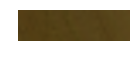

22.0


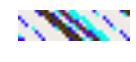

11.0


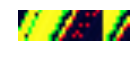

38.0


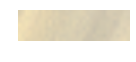

36.0


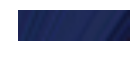

37.0


In [34]:
for i in range(5):
    img = deprocess(solver.net.blobs['data'].data[i]) 
    #print img.shape
    plt.figure(figsize=(2,2))
    plt.axis('off')
    plt.imshow(img[...])
    plt.show()
    print solver.net.blobs['disp'].data[i]

In [35]:
solver.step(1)

In [36]:
#plt.imshow(solver.net.params['conv1'][0].diff.reshape(16, 12, 3, 3).transpose(0, 2, 1, 3).reshape(16*3, 12*3))  #, cmap='gray'
#plt.axis('off')
#plt.show()

In [38]:
def draw_loss_acc(niter,test_interval,train_loss,test_acc):
    _, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax1.plot(np.arange(niter), train_loss)
    ax2.plot(test_interval * np.arange(len(test_acc)), test_acc, 'r')
    ax1.set_xlabel('iteration')
    ax1.set_ylabel('train loss')
    ax2.set_ylabel('test accuracy')
    ax2.set_title('Test Accuracy: {:.3f}'.format(test_acc[-1]))
    plt.show()

In [39]:
#%%time
niter = 60000  
test_img_num = 80000
test_batch_size = 400
test_iter = 200
test_interval = 2000 # 440*2000=880000 
train_loss = np.zeros(niter)
test_acc = np.zeros(int(np.ceil(niter / float(test_interval))))
#test_acc = np.zeros(np.ceil(niter/test_interval))
img_num = 8
#output = np.zeros((niter,img_num,59))

for it in range(niter):
    solver.step(1)  #do 1 iteration, for and backward
    train_loss[it] = solver.net.blobs['loss'].data
    
    solver.test_nets[0].forward(start='conv1')
    #output[it] = solver.test_nets[0].blobs['fc5'].data[:img_num]  #fc4 下面也要改
    
    if it%test_interval == 0:
        print 'Iteration', it, 'testing...'
        correct = 0
        for test_it in range(test_iter):
            solver.test_nets[0].forward()  #step(1) includes backward()
            correct += sum(solver.test_nets[0].blobs['fc5'].data.argmax(1) == solver.test_nets[0].blobs['disp'].data)
        #print correct
        test_acc[it // test_interval] = correct / float(test_img_num) #do not use /, / is floor divi
        #draw after one test
        #draw_loss_acc(niter,test_interval,train_loss,test_acc)
        
    '''
    for j in range(test_batch_size):
                print solver.test_nets[0].blobs['fc4'].data.argmax(1)[j],"({})".format(solver.test_nets[0].blobs['disp'].data[j]),solver.test_nets[0].blobs['fc4'].data.argmax(1)[j] == solver.test_nets[0].blobs['disp'].data[j]
                if(solver.test_nets[0].blobs['fc4'].data.argmax(1)[j] == solver.test_nets[0].blobs['disp'].data[j]):
                    correct += 1
    '''

Iteration 0 testing...
Iteration 2000 testing...
Iteration 4000 testing...
Iteration 6000 testing...
Iteration 8000 testing...
Iteration 10000 testing...
Iteration 12000 testing...
Iteration 14000 testing...
Iteration 16000 testing...
Iteration 18000 testing...
Iteration 20000 testing...
Iteration 22000 testing...
Iteration 24000 testing...
Iteration 26000 testing...
Iteration 28000 testing...
Iteration 30000 testing...
Iteration 32000 testing...
Iteration 34000 testing...
Iteration 36000 testing...
Iteration 38000 testing...
Iteration 40000 testing...
Iteration 42000 testing...
Iteration 44000 testing...
Iteration 46000 testing...
Iteration 48000 testing...
Iteration 50000 testing...
Iteration 52000 testing...
Iteration 54000 testing...
Iteration 56000 testing...
Iteration 58000 testing...


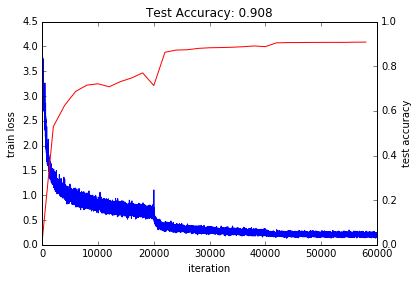

In [40]:
draw_loss_acc(niter,test_interval,train_loss,test_acc)

In [41]:
filename2value = lambda x: x[:x.rfind('.')].split('_')[-1]
WEIGHTS_FILE = 'disp_train_iter_60000.caffemodel'
DEPLOY_FILE = 'deploy.prototxt'
IMAGE_SIZE = (9, 33) #h,w
MEAN_FILE = 'lmdb_data/test_mean.npy'  #not binaryproto, do convert_mean.py first
IMAGE_LIST = 'test.txt'
PRECISION = 0.07
OFFSET = 2

caffe.set_device(0)
caffe.set_mode_gpu()  
net = caffe.Net(DEPLOY_FILE, WEIGHTS_FILE, caffe.TEST)
net.blobs['data'].reshape(1, 3, *IMAGE_SIZE)
#print net.blobs['data'].data.shape

#图片预处理设置
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})  #设定图片的shape格式(1,3,9,33)
transformer.set_transpose('data', (2,0,1))    #改变维度的顺序，由原始图片(9,33,3)变为(3,9,33)
transformer.set_mean('data', np.load(MEAN_FILE))    #减去均值，前面训练模型时没有减均值，这儿就不用
# ATTENTION: scale 255 is required，or the network will output same prediction
transformer.set_raw_scale('data', 255)    # 缩放到【0，255】之间
transformer.set_channel_swap('data', (2,1,0))   #交换通道，将图片由RGB变为BGR
'''
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
transformer.set_transpose('data', (2,0,1))
transformer.set_mean('data', numpy.array([MEAN_VALUE]))
transformer.set_raw_scale('data', 255)

'''

#image_list = sys.argv[1]
lb_correct = 0
va_correct = 0
with open(IMAGE_LIST, 'r') as f:
    #print type(f)
    lines = f.readlines()
    print "{} Test images.".format(len(lines))
    for line in lines:
        filename = line[:-1]
        image = caffe.io.load_image(filename) #, False gray or rgb
        #print image.shape
        transformed_image = transformer.preprocess('data', image)
        net.blobs['data'].data[...] = transformed_image

        output = net.forward()
        
        disp_gt = float(filename2value(filename))
        lb_gt = int((disp_gt + OFFSET)/PRECISION + 0.5) #disp四舍五入
        disp_pre = net.blobs['fc5'].data.argmax(1)[0] * PRECISION - OFFSET  #do not forget [0]
        lb_pre =  net.blobs['fc5'].data.argmax(1)[0]
        #print disp_pre,disp_gt,lb_pre,lb_gt
        if lb_gt == lb_pre:
            lb_correct += 1
            #print lb_gt ,lb_pre
        if abs(disp_pre  - disp_gt) <= PRECISION:
            va_correct += 1
            #print  net.blobs['fc5'].data.argmax(1)
        '''
        else:
            #disp the image、pre and GT
            plt.figure(figsize=(2,2))
            plt.axis('off')
            plt.imshow(image)
            plt.show()
            print "{}({})".format(disp_pre,disp_gt)
        '''
print  "Label accuracy:{}".format(float(lb_correct) / len(lines))
print  "Value({}) accuracy:{}".format(PRECISION,float(va_correct) / len(lines))         
#print "Accuracy on Test dataset: {}".format(correct / float(f))


88576 Test images.
-0.95 -0.925261 15 15
0.8 0.781532 40 40
0.24 0.208434 32 32
-0.6 -0.60889 20 20
1.01 1.039652 43 43
-0.74 -0.722474 18 18
-0.95 -0.971285 15 15
0.59 0.615638 37 37
-1.37 -1.381195 9 9
1.15 1.175496 45 45
-1.16 -1.150119 12 12
0.66 0.645789 38 38
-0.04 -0.045201 28 28
0.38 0.385018 34 34
0.03 0.036398 29 29
-1.02 -1.017492 14 14
0.45 0.546256 35 36
0.03 0.029511 29 29
1.15 1.149866 45 45
-1.3 -1.322942 10 10
-1.23 -1.236206 11 11
0.73 0.753074 39 39
-1.37 -1.381465 9 9
-0.46 -0.445798 22 22
-0.67 -0.696 19 19
1.08 1.062069 44 44
-1.16 -1.172012 12 12
-1.51 -1.482198 7 7
0.59 0.62196 37 37
1.08 1.108098 44 44
0.87 0.902034 41 41
1.22 1.23364 46 46
-0.04 -0.043506 28 28
-1.37 -1.347004 9 9
0.17 0.137707 31 31
0.1 0.155402 30 31
0.66 0.684771 38 38
-1.37 -1.385472 9 9
-0.53 -0.547207 21 21
-1.09 -1.081401 13 13
-0.67 -0.675219 19 19
-0.74 -0.713516 18 18
-1.37 -1.343217 9 9
0.45 0.432742 35 35
-0.46 -0.494366 22 22
-1.44 -1.404957 8 9
-0.32 -0.281513 24 25
0.87 0.835401

'\nsideboard:\n17568 Test images.\nLabel accuracy:0.935166211293\nValue(0.07) accuracy:0.985826502732\n'

In [ ]:
'''
sideboard:
17568 Test images.
Label accuracy:0.935166211293
Value(0.07) accuracy:0.985826502732
'''
'''
deploy.prototxt batch_size = 512
每个图片都生一个test.txt将patches依序列好，同样算lmdb
预测输出pfmji
'''

In [177]:
print np.load(MEAN_FILE).shape

(3, 9, 33)


31.0


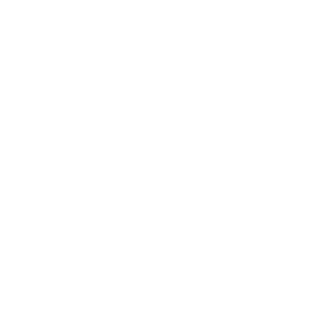

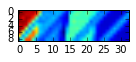

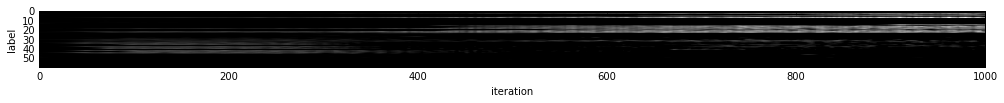

38.0


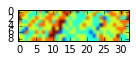

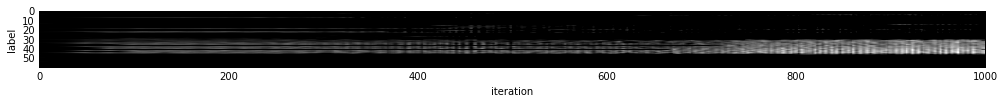

34.0


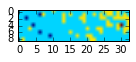

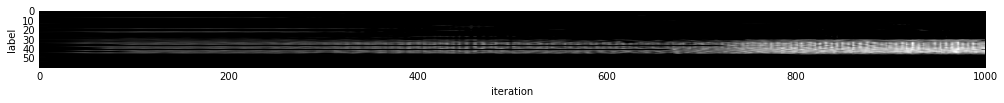

21.0


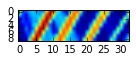

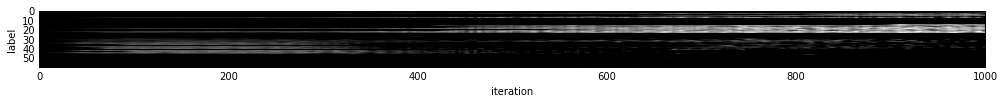

38.0


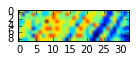

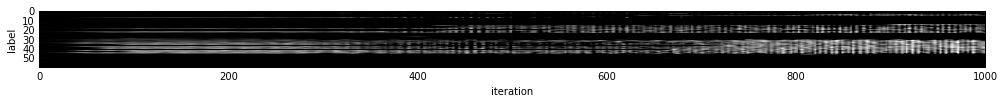

35.0


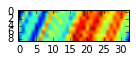

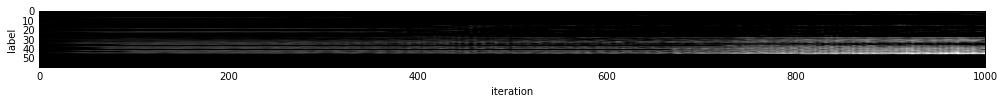

31.0


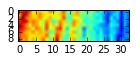

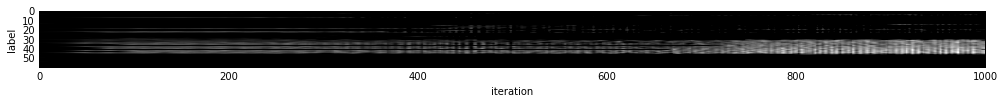

30.0


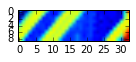

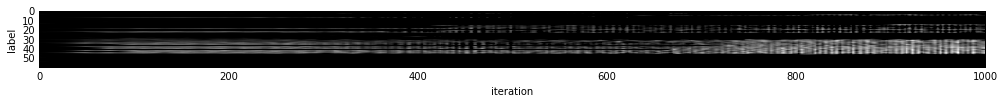

In [132]:
for i in range(img_num):
    print solver.test_nets[0].blobs['disp'].data[i]
    figure(figsize=(2, 2))
    imshow(solver.test_nets[0].blobs['data'].data[i, 0])
    figure(figsize=(100, 1))
    imshow(output[:1000, i].T, interpolation='nearest', cmap='gray')
    xlabel('iteration')
    ylabel('label')
    plt.show()
plt.close()

In [111]:
print test_acc

[ 0.00515  0.0735   0.07255  0.0926   0.1048   0.12115  0.14725  0.1386
  0.14685  0.1529   0.1488   0.1667   0.1686   0.1685   0.1692   0.17015
  0.1701   0.16985  0.16945  0.1694 ]


Iteration 19999 testing...


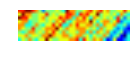

41 ( 42.0 )


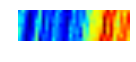

41 ( 31.0 )


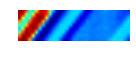

41 ( 40.0 )


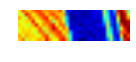

41 ( 25.0 )


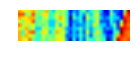

41 ( 29.0 )


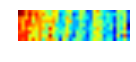

41 ( 30.0 )


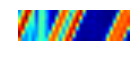

41 ( 35.0 )


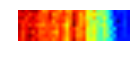

41 ( 29.0 )


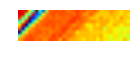

41 ( 44.0 )


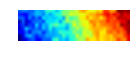

41 ( 21.0 )


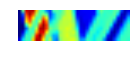

41 ( 26.0 )


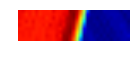

41 ( 32.0 )


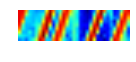

41 ( 28.0 )


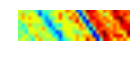

41 ( 18.0 )


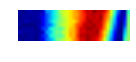

41 ( 29.0 )


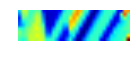

41 ( 26.0 )


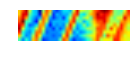

41 ( 35.0 )


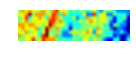

41 ( 35.0 )


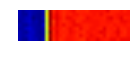

41 ( 30.0 )


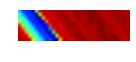

41 ( 17.0 )


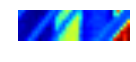

41 ( 30.0 )


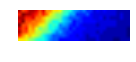

41 ( 43.0 )


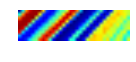

41 ( 44.0 )


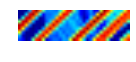

41 ( 17.0 )


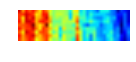

41 ( 27.0 )


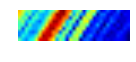

41 ( 39.0 )


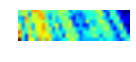

41 ( 23.0 )


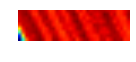

41 ( 21.0 )


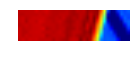

41 ( 33.0 )


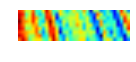

41 ( 24.0 )


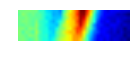

41 ( 34.0 )


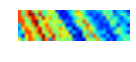

41 ( 19.0 )


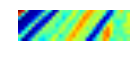

41 ( 18.0 )


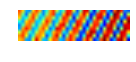

41 ( 37.0 )


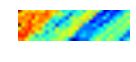

41 ( 46.0 )


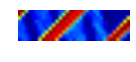

41 ( 44.0 )


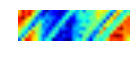

41 ( 33.0 )


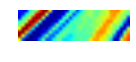

41 ( 26.0 )


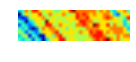

41 ( 15.0 )


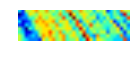

41 ( 19.0 )


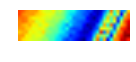

41 ( 37.0 )


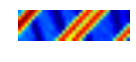

41 ( 42.0 )


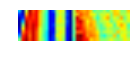

41 ( 28.0 )


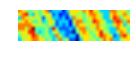

41 ( 21.0 )


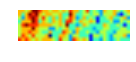

41 ( 34.0 )


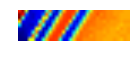

41 ( 38.0 )


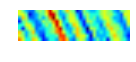

41 ( 22.0 )


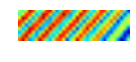

41 ( 42.0 )


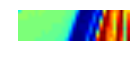

41 ( 34.0 )


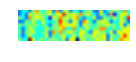

41 ( 33.0 )


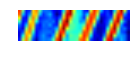

41 ( 29.0 )


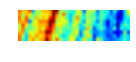

41 ( 32.0 )


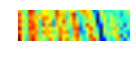

41 ( 26.0 )


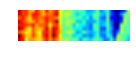

41 ( 29.0 )


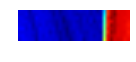

41 ( 24.0 )


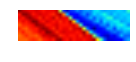

41 ( 9.0 )


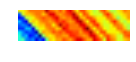

41 ( 14.0 )


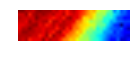

41 ( 39.0 )


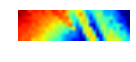

41 ( 40.0 )


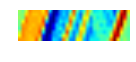

41 ( 33.0 )


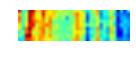

41 ( 29.0 )


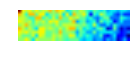

41 ( 38.0 )


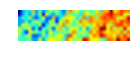

41 ( 38.0 )


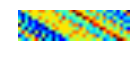

41 ( 4.0 )


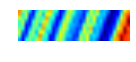

41 ( 34.0 )


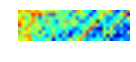

41 ( 44.0 )


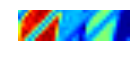

41 ( 43.0 )


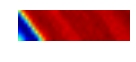

41 ( 18.0 )


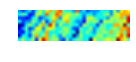

41 ( 37.0 )


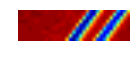

41 ( 39.0 )


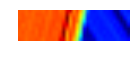

41 ( 32.0 )


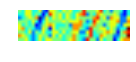

41 ( 35.0 )


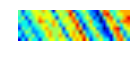

41 ( 20.0 )


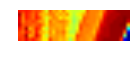

41 ( 28.0 )


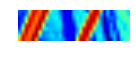

41 ( 27.0 )


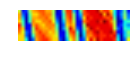

41 ( 17.0 )


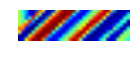

41 ( 45.0 )


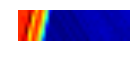

41 ( 19.0 )


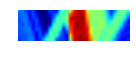

41 ( 26.0 )


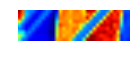

41 ( 30.0 )


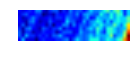

41 ( 34.0 )


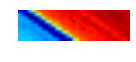

41 ( 7.0 )


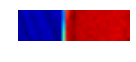

41 ( 29.0 )


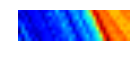

41 ( 22.0 )


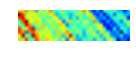

41 ( 16.0 )


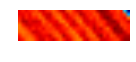

41 ( 15.0 )


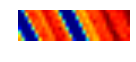

41 ( 21.0 )


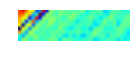

41 ( 43.0 )


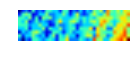

41 ( 36.0 )


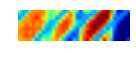

41 ( 44.0 )


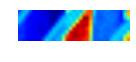

41 ( 41.0 )


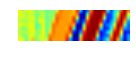

41 ( 34.0 )


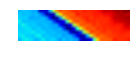

41 ( 6.0 )


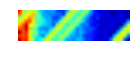

41 ( 42.0 )


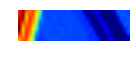

41 ( 20.0 )


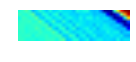

41 ( 9.0 )


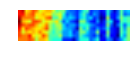

41 ( 30.0 )


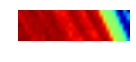

41 ( 20.0 )


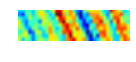

41 ( 22.0 )


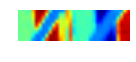

41 ( 27.0 )


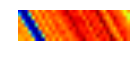

41 ( 20.0 )


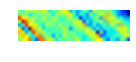

41 ( 11.0 )


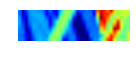

41 ( 23.0 )


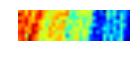

41 ( 32.0 )


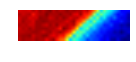

41 ( 45.0 )


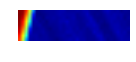

41 ( 20.0 )


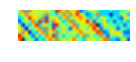

41 ( 14.0 )


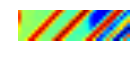

41 ( 43.0 )


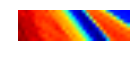

41 ( 17.0 )


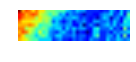

41 ( 37.0 )


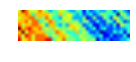

41 ( 15.0 )


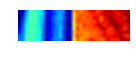

41 ( 20.0 )


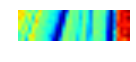

41 ( 30.0 )


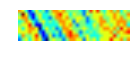

41 ( 20.0 )


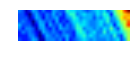

41 ( 21.0 )


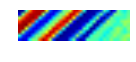

41 ( 45.0 )


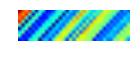

41 ( 43.0 )


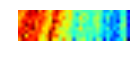

41 ( 31.0 )


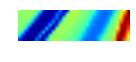

41 ( 38.0 )


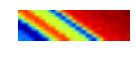

41 ( 7.0 )


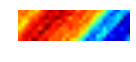

41 ( 43.0 )


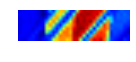

41 ( 30.0 )


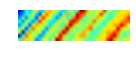

41 ( 42.0 )


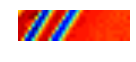

41 ( 38.0 )


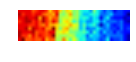

41 ( 30.0 )


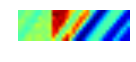

41 ( 40.0 )


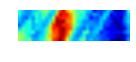

41 ( 38.0 )


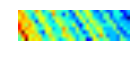

41 ( 19.0 )


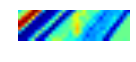

41 ( 27.0 )


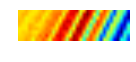

41 ( 37.0 )


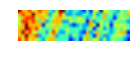

41 ( 34.0 )


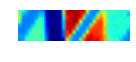

41 ( 28.0 )


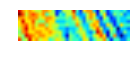

41 ( 22.0 )


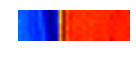

41 ( 29.0 )


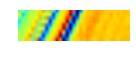

41 ( 36.0 )


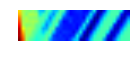

41 ( 25.0 )


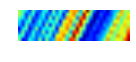

41 ( 36.0 )


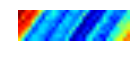

41 ( 40.0 )


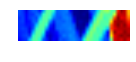

41 ( 23.0 )


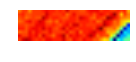

41 ( 42.0 )


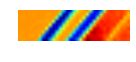

41 ( 41.0 )


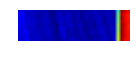

41 ( 25.0 )


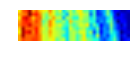

41 ( 27.0 )


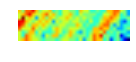

41 ( 39.0 )


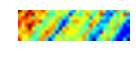

41 ( 39.0 )


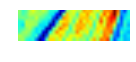

41 ( 37.0 )


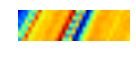

41 ( 36.0 )


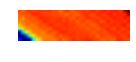

41 ( 7.0 )


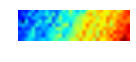

41 ( 36.0 )


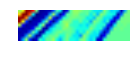

41 ( 19.0 )


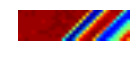

41 ( 44.0 )


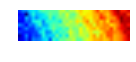

41 ( 22.0 )


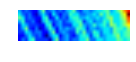

41 ( 22.0 )


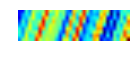

41 ( 34.0 )


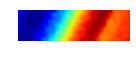

41 ( 36.0 )


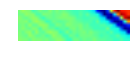

41 ( 9.0 )


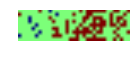

41 ( 39.0 )


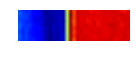

41 ( 29.0 )


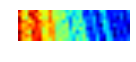

41 ( 26.0 )


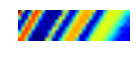

41 ( 38.0 )


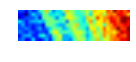

41 ( 21.0 )


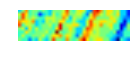

41 ( 36.0 )


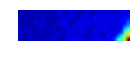

41 ( 39.0 )


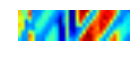

41 ( 28.0 )


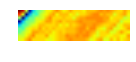

41 ( 43.0 )


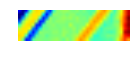

41 ( 31.0 )


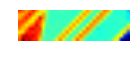

41 ( 43.0 )


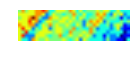

41 ( 41.0 )


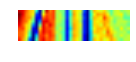

41 ( 29.0 )


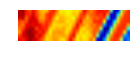

41 ( 36.0 )


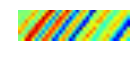

41 ( 40.0 )


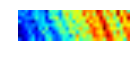

41 ( 22.0 )


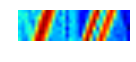

41 ( 28.0 )


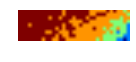

41 ( 44.0 )


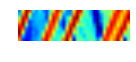

41 ( 35.0 )


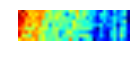

41 ( 32.0 )


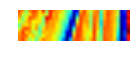

41 ( 33.0 )


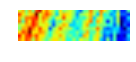

41 ( 33.0 )


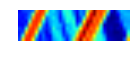

41 ( 18.0 )


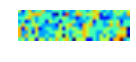

41 ( 35.0 )


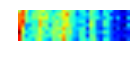

41 ( 29.0 )


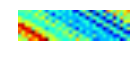

41 ( 4.0 )


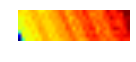

41 ( 22.0 )


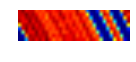

41 ( 20.0 )


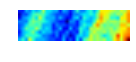

41 ( 36.0 )


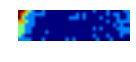

41 ( 34.0 )


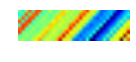

41 ( 43.0 )


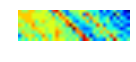

41 ( 12.0 )


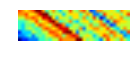

41 ( 7.0 )


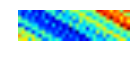

41 ( 4.0 )


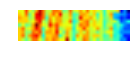

41 ( 30.0 )


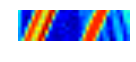

41 ( 27.0 )


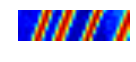

41 ( 25.0 )


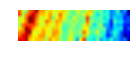

41 ( 33.0 )


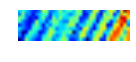

41 ( 36.0 )


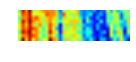

41 ( 27.0 )


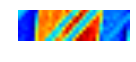

41 ( 42.0 )


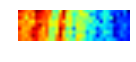

41 ( 30.0 )


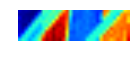

41 ( 30.0 )


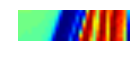

41 ( 34.0 )


In [138]:
#修改test数据集
print 'Iteration', it, 'testing...'
rows,cols = 100,2
correct = 0
#plt.cla()
for test_it in range(1):
    solver.test_nets[0].forward()  #step(1) includes backward()
    for i in range(test_batch_size):
        plt.figure(figsize=(2, 2))
        plt.axis('off')
        #use subplot, not subplots
        #plt.subplot(rows,cols,i+1) #(i-1)%cols+1
        plt.imshow(solver.test_nets[0].blobs['data'].data[i, 0])
        plt.show()
        print solver.test_nets[0].blobs['fc4'].data.argmax(1)[i],"(",solver.test_nets[0].blobs['disp'].data[i],")"
    
    correct += sum(solver.test_nets[0].blobs['fc4'].data.argmax(1)
                   == solver.test_nets[0].blobs['disp'].data)
    #print correct / test_img_num
    test_acc[it // test_interval] = correct / float(test_img_num)

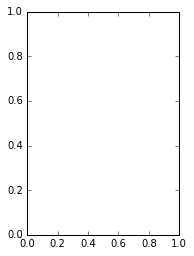

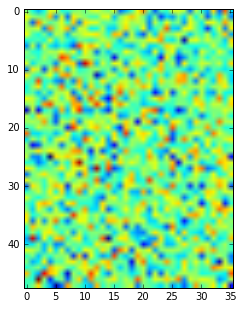

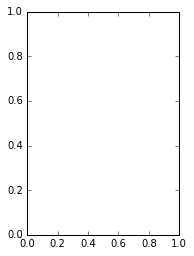

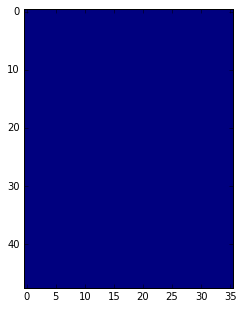

In [163]:
#[('conv1', (64, 3, 3, 3)), ('conv2', (128, 64, 3, 3)), ('fc3', (1024, 4480)), ('fc4', (59, 1024))]
rows,cols = 1,2
plt.subplot(rows,cols,1)
plt.figure(figsize=(5, 5))
plt.imshow(solver.net.params['conv1'][0].data.reshape(16, 12, 3, 3)
       .transpose(0, 2, 1, 3).reshape(16*3, 12*3))  #, cmap='gray'
#plt.axis('off')
plt.show()

plt.subplot(rows,cols,1)
plt.figure(figsize=(5, 5))
plt.imshow(solver.net.params['conv1'][0].diff.reshape(16, 12, 3, 3)
       .transpose(0, 2, 1, 3).reshape(16*3, 12*3))  #, cmap='gray'
plt.show()

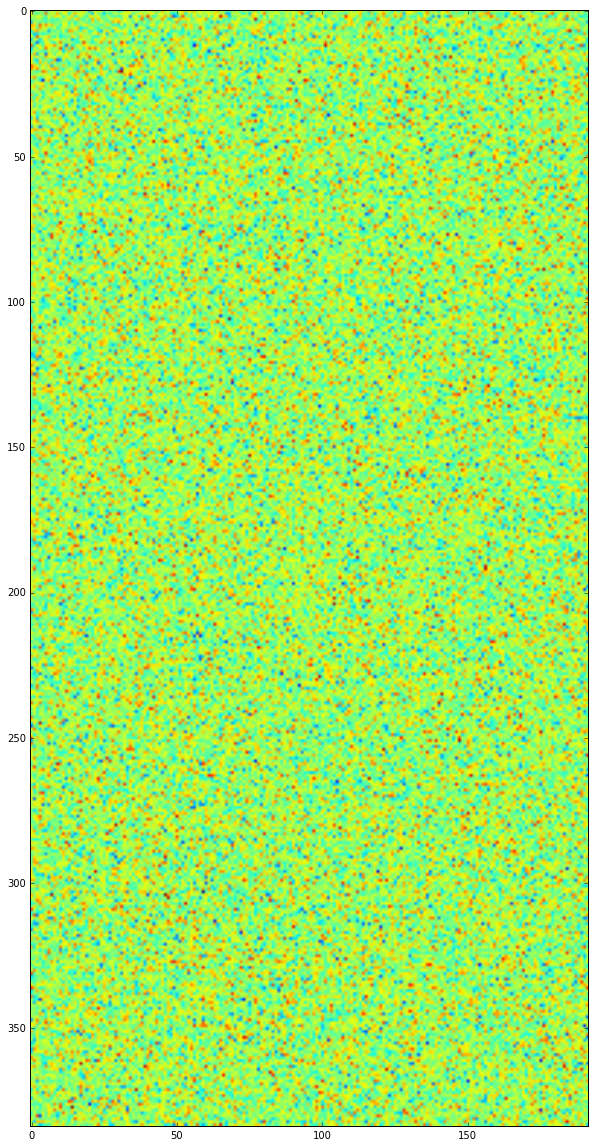

In [164]:
#reshape is required
plt.figure(figsize=(20, 20))
plt.imshow(solver.net.params['conv2'][0].data.reshape(128, 64, 3, 3).transpose(0, 2, 1, 3).reshape(128*3, 64*3))  #, cmap='gray'
plt.show()